# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [1]:
from typing import Any

from numpy import floating
!pip install transformers torch  # For BERT
!pip install -r requirements.txt
# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:
BERT libraries loaded successfully!
Using device: cuda


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
import time, math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(10)

print("Libraries imported successfully!")

Libraries imported successfully!


# Load dataset

In [4]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('data/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('data/test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [2]:
movies = pd.read_csv('data/movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

In [8]:
from ast import List
from recommendation_algorithms.hybrid_recommender import HybridRecommender
from recommendation_algorithms.matrix_factorization import MatrixFactorizationSGD
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking
from recommendation_algorithms.item_knn import ItemKNN
from recommendation_algorithms.user_knn import UserKNN

# TODO add others
item_knn = ItemKNN(k=8)
user_knn = UserKNN(k=8)
matrix_factorization = MatrixFactorizationSGD()
bpr = BayesianProbabilisticRanking()
rating_recommenders = [matrix_factorization, item_knn, user_knn]
ranking_recommenders = [matrix_factorization, bpr, item_knn, user_knn]
max_k = 10 # Recommendation list size
ranking_weights = {
	'Matrix Factorization': 0.25,
	'Bayesian Probabilistic Ranking': 0.25,
	'Item KNN': 0.25,
	'User KNN': 0.25,
}
hybrid_recommender = HybridRecommender(train_data, rating_recommenders, ranking_recommenders, max_k, ranking_weights, True)

Started training hybrid recommender on 943 users and 1650 items...
Training individual models...
  Loaded predictions for Matrix Factorization from checkpoint.
Finished training individual models.
Started linear regression...
[INFO] Visualization saved to: plots\linear_regression_rating_2025-10-25_17-13-44.png
Finished rating linear regression, weights are:
  Matrix Factorization: 1.0064251219379128
Precomputing predictions...
Finished computing predictions, model is ready to use.


In [17]:
user_id = 12
item_id = 2
# predicted_score = hybrid_recommender.predict_score(user_id, item_id)
# actual_score = train_data.loc[((train_data['user_id'] == user_id) & (train_data['item_id'] == item_id)), 'rating'].values[0]
# print(f'Predicted score {predicted_score} for user {user_id} and item {item_id}, actual score: {actual_score}.')

predicted_ranking = hybrid_recommender.predict_ranking(user_id, max_k)
user_df = train_data.loc[(train_data['user_id'] == user_id), ['item_id', 'rating']]
actual_ranking = (
        user_df.nlargest(max_k, 'rating')
        .apply(lambda row: (row['item_id'], row['rating']), axis=1)
        .tolist()
)
print(f"Predicted & actual ranking for user {user_id}")
for i in range(len(predicted_ranking)):
    print(f"  {i + 1}: predicted: {predicted_ranking[i]} & actual: {actual_ranking[i]}")

Predicted & actual ranking for user 12
  1: predicted: (169.0, 2.04675061048853) & actual: (4, 5)
  2: predicted: (64.0, 1.5009403017981806) & actual: (69, 5)
  3: predicted: (174.0, 1.4737886923553705) & actual: (88, 5)
  4: predicted: (313.0, 1.4581417319824816) & actual: (98, 5)
  5: predicted: (173.0, 1.4577209608831918) & actual: (161, 5)
  6: predicted: (12.0, 1.4542368113017816) & actual: (174, 5)
  7: predicted: (272.0, 1.4535505704551945) & actual: (216, 5)
  8: predicted: (50.0, 1.4319056428968764) & actual: (238, 5)
  9: predicted: (408.0, 1.4278526031084255) & actual: (242, 5)
  10: predicted: (22.0, 1.4267876525919148) & actual: (591, 5)


#### Test BPR Out 

In [ ]:
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking

bpr = BayesianProbabilisticRanking()
bpr.train(train_data)   

#### User-based Collaborative Filtering

In [ ]:
from recommendation_algorithms.user_knn import UserKNN

In [5]:
u_knn = UserKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

u_knn.train(df)

4it [00:00, 697.74it/s]


In [6]:
u_knn.predict_score(4, 3)

users_that_rated_i: 
[1, 2, 3]
sim_matrix_masked: 
          1    2         3    4
1  0.000000  0.0 -0.755929  1.0
2  0.000000  0.0  0.000000  0.0
3 -0.755929  0.0  0.000000  0.0
sims: 
2    0.000000
1   -0.755929
Name: 3, dtype: float64
ni 
[2 1]
rvi 
[4 2]
rv 
[4.         3.33333333]


np.float64(5.333333333333334)

### Item-based Collaborative Filtering

In [48]:
from recommendation_algorithms.item_knn import ItemKNN

In [49]:
i_knn = ItemKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

i_knn.train(df)




3it [00:00, 1528.35it/s]


In [50]:
i_knn.predict_score(4, 3)

np.float64(3.954941986653667)

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

## Code

## Evaluation scripts

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


### Rating task

In [2]:
# EVALUATION functions
from sklearn.metrics import root_mean_squared_error

def evaluate_rating(ground_truth: list[float], predictions: list[float]) -> float:
    """
    Evaluation function for one model for rating prediction task - RMSE. Takes two lists of rating values as input and returns RMSE and MSE. Assumes that the two lists are aligned (i.e., the i-th element in each list corresponds to the same user-item pair).

    :param ground_truth: list of actual ratings
    :param predictions:  list of predicted ratings
    :return: float
    """
    return root_mean_squared_error(ground_truth, predictions)

def evaluate_rating_all():
    pass

In [3]:
# DEBUG - example

gt = [4.0, 3.5, 5.0, 2.0]
preds = [3.5, 3.0, 4.5, 2.5]

rmse = evaluate_rating(gt, preds)
print(f'RMSE: {rmse:.4f}')

RMSE: 0.5000


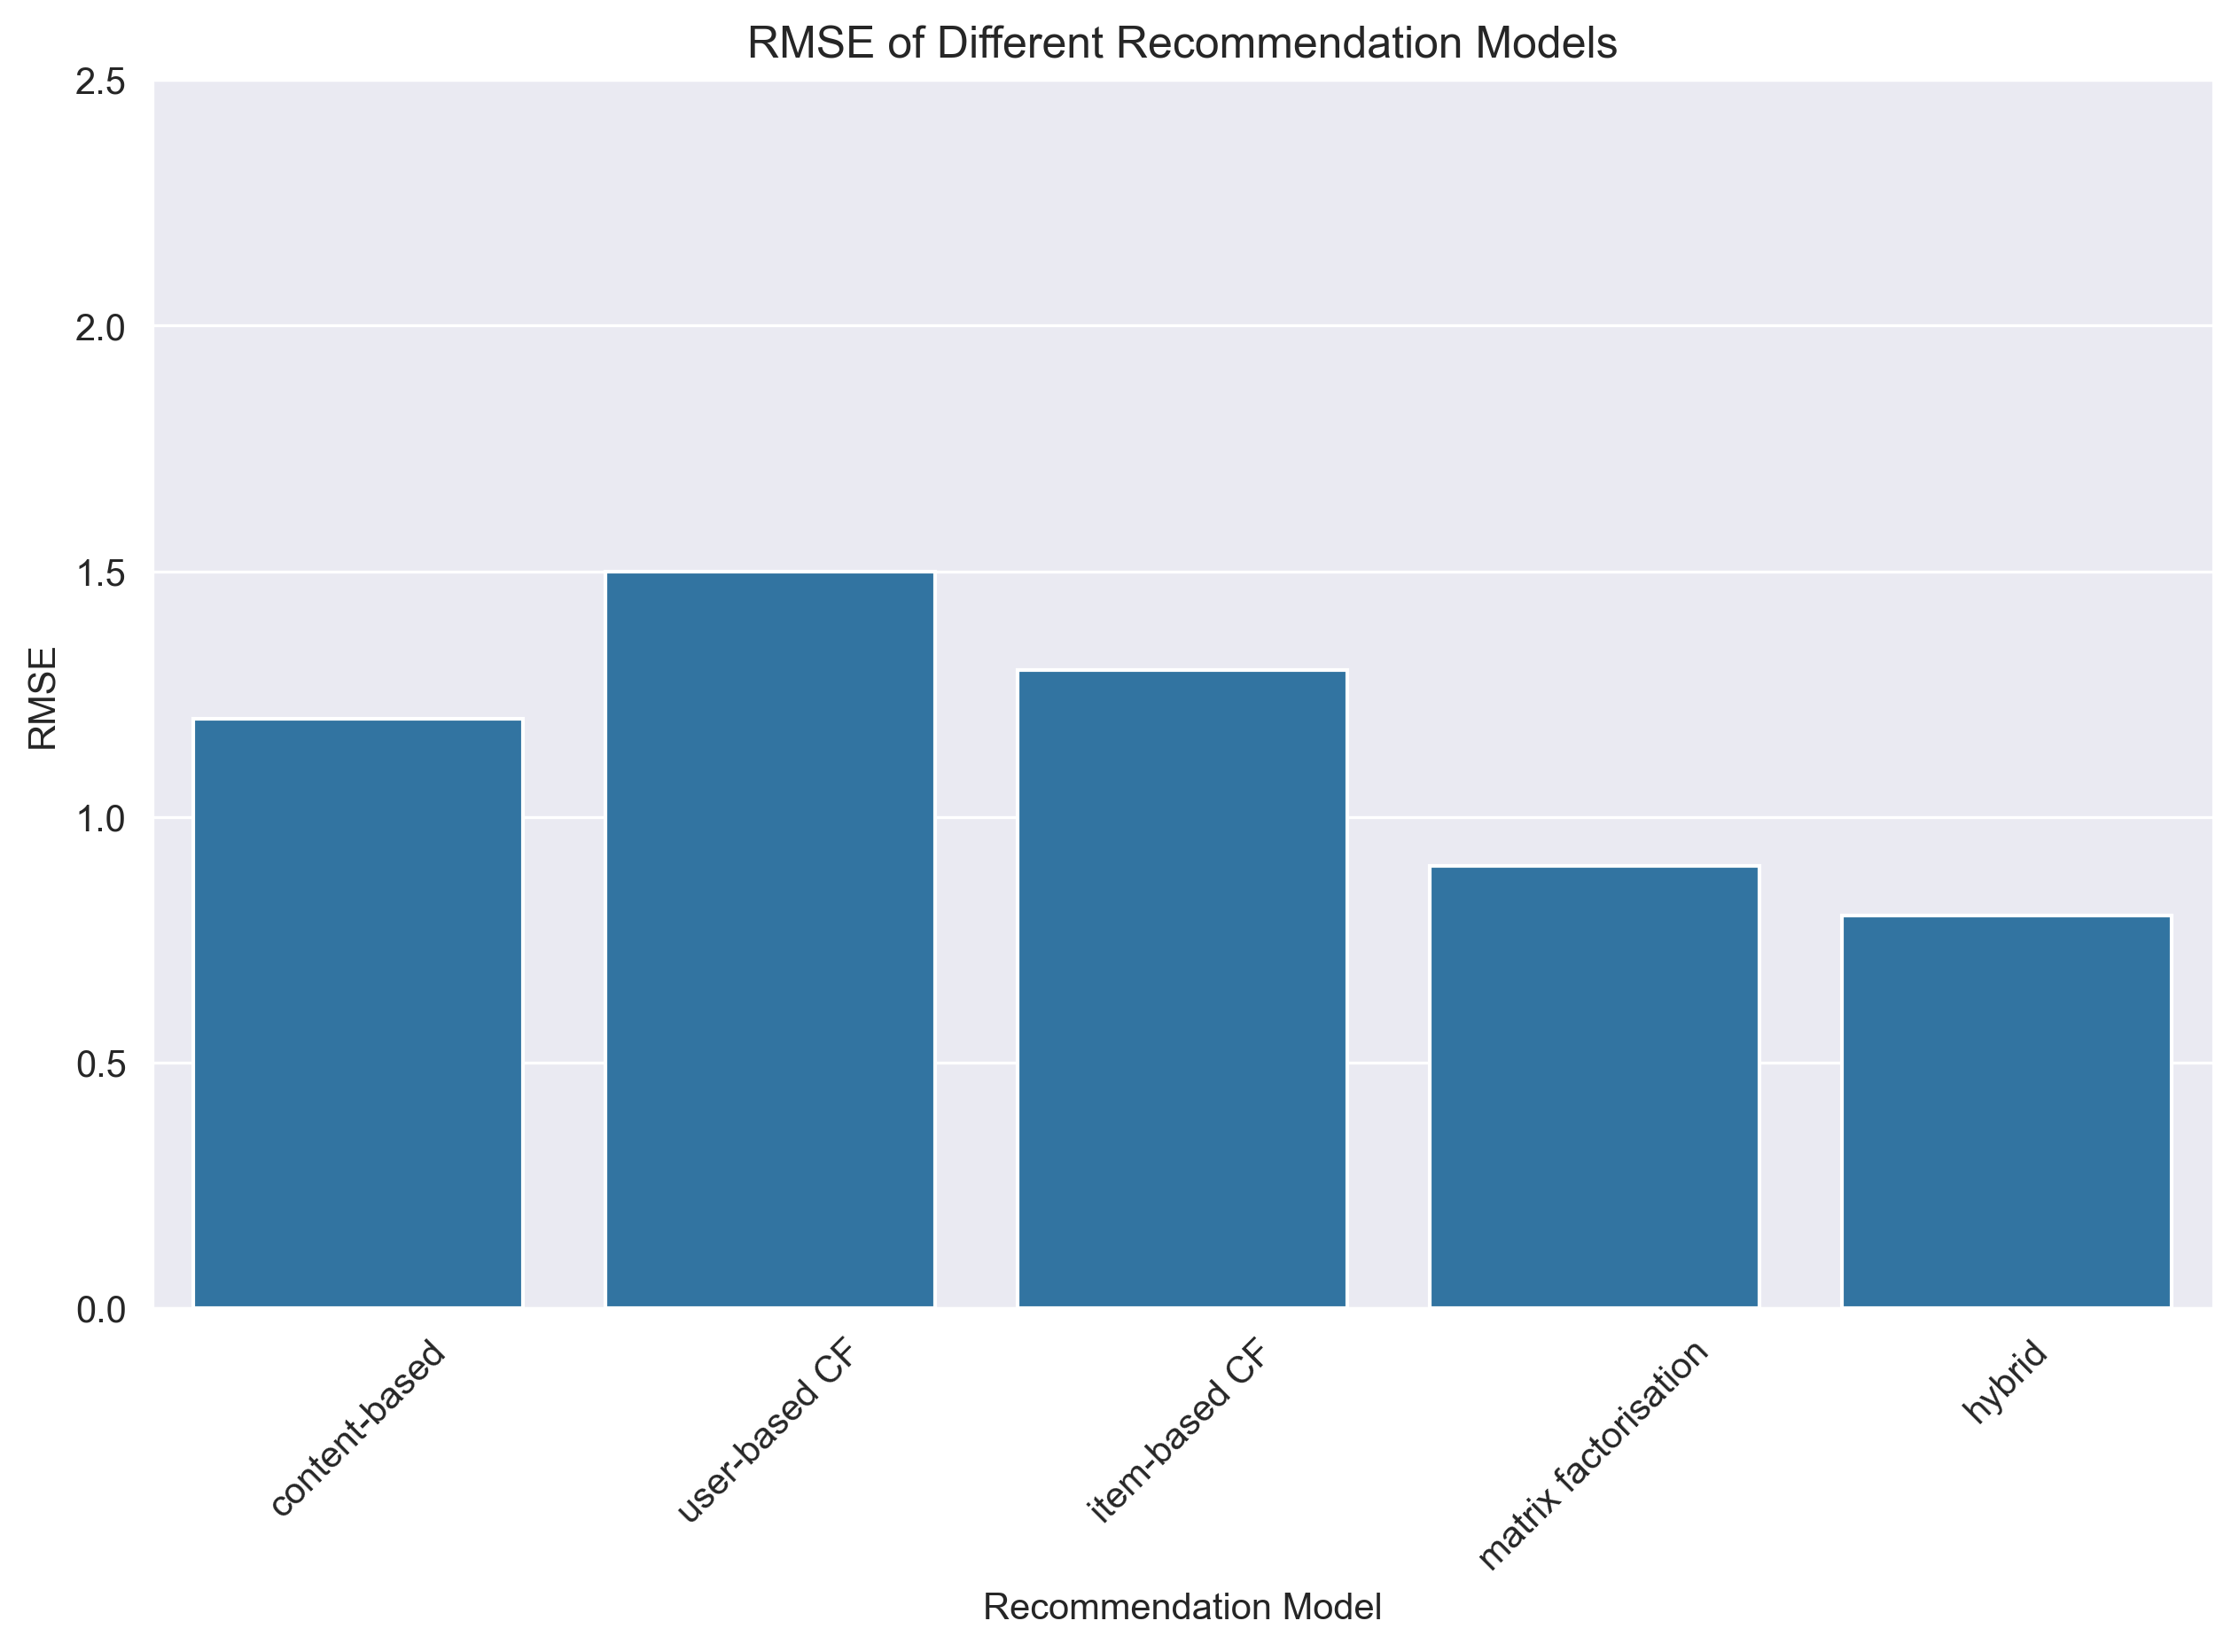

In [19]:
# VISUALISATION

results_rating = {
    'content-based' : 1.2,
    'user-based CF' : 1.5,
    'item-based CF' : 1.3,
    'matrix factorisation' : 0.9,
    'hybrid' : 0.8,
}

def plot_rating_results(results: dict):
    """
    Plot RMSE results for different recommendation models. (This function was generated using Copilot, then debugged)

    :param results: dictionary where keys are model names and values are RMSE scores
    """
    models = list(results.keys())
    rmse_scores = list(results.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=rmse_scores)
    plt.title('RMSE of Different Recommendation Models')
    plt.xlabel('Recommendation Model')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_scores) + 1)
    plt.xticks(rotation=45)  # readability
    plt.show()

plot_rating_results(results_rating)

### Ranking task

In [8]:
# Evaluation ranking task

def ndcg(ground_truth, rec_list, k = 10) -> float:
    if k > len(rec_list):
        k = len(rec_list)
    dcg = 0.0
    for i in range(k):
        numerator = 1 if rec_list[i] in ground_truth else 0
        denominator = np.log2(i + 2)
        dcg += numerator / denominator
    ideal_len = min(k, len(ground_truth))
    if ideal_len == 0:
        return 0.0
    else:
        IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
        return dcg / IDCG


def evaluate_ranking(ground_truth: list[list], rec_list: list[list], k=10) -> tuple[
    floating[Any], floating[Any], floating[Any]]:
    """
    Calculate Precision, Recall, and NDCG for ranking task.

    Assume that items in rec_list are relevant (rel = 1) and items not in rec_list are non-relevant (rel = 0).

    :param ground_truth: lists of list of item ids that are relevant
    :param rec_list: list of recommended top-k item ids
    :param k: cut-off for ndcg (may change to be for P and R as well) - TODO
    :return:
    """
    # Compute Precision & Recall
    len_intersections = np.array([len(set(gt).intersection(set(rl))) for rl, gt in zip(rec_list, ground_truth)])
    len_rls = np.array([len(rl) for rl in rec_list])
    len_gts = np.array([len(gt) for gt in ground_truth])

    p = np.nanmean(100 * len_intersections / len_rls)  # precision
    r = np.nanmean(100 * len_intersections / len_gts)  # recall

    # Compute NDCG
    ndcgs = [ndcg(gt, rl, k) for rl, gt in zip(rec_list, ground_truth)]
    ndcg_mean = np.mean(ndcgs)

    return p, r, ndcg_mean

def evaluate_ranking_all():
    pass

In [9]:
# DEBUG - example use

ground_truth = [[1, 2, 3], [2, 3, 4], [1, 4]]
rec_list = [[2, 3, 5], [1, 2, 3], [4, 5, 6]]

precision, recall, ndcg_mean = evaluate_ranking(ground_truth, rec_list, k=3)
print(f'Precision: {precision:.2f}%, Recall: {recall:.2f}%, NDCG: {ndcg_mean:.4f}')

Precision: 55.56%, Recall: 61.11%, NDCG: 0.6364


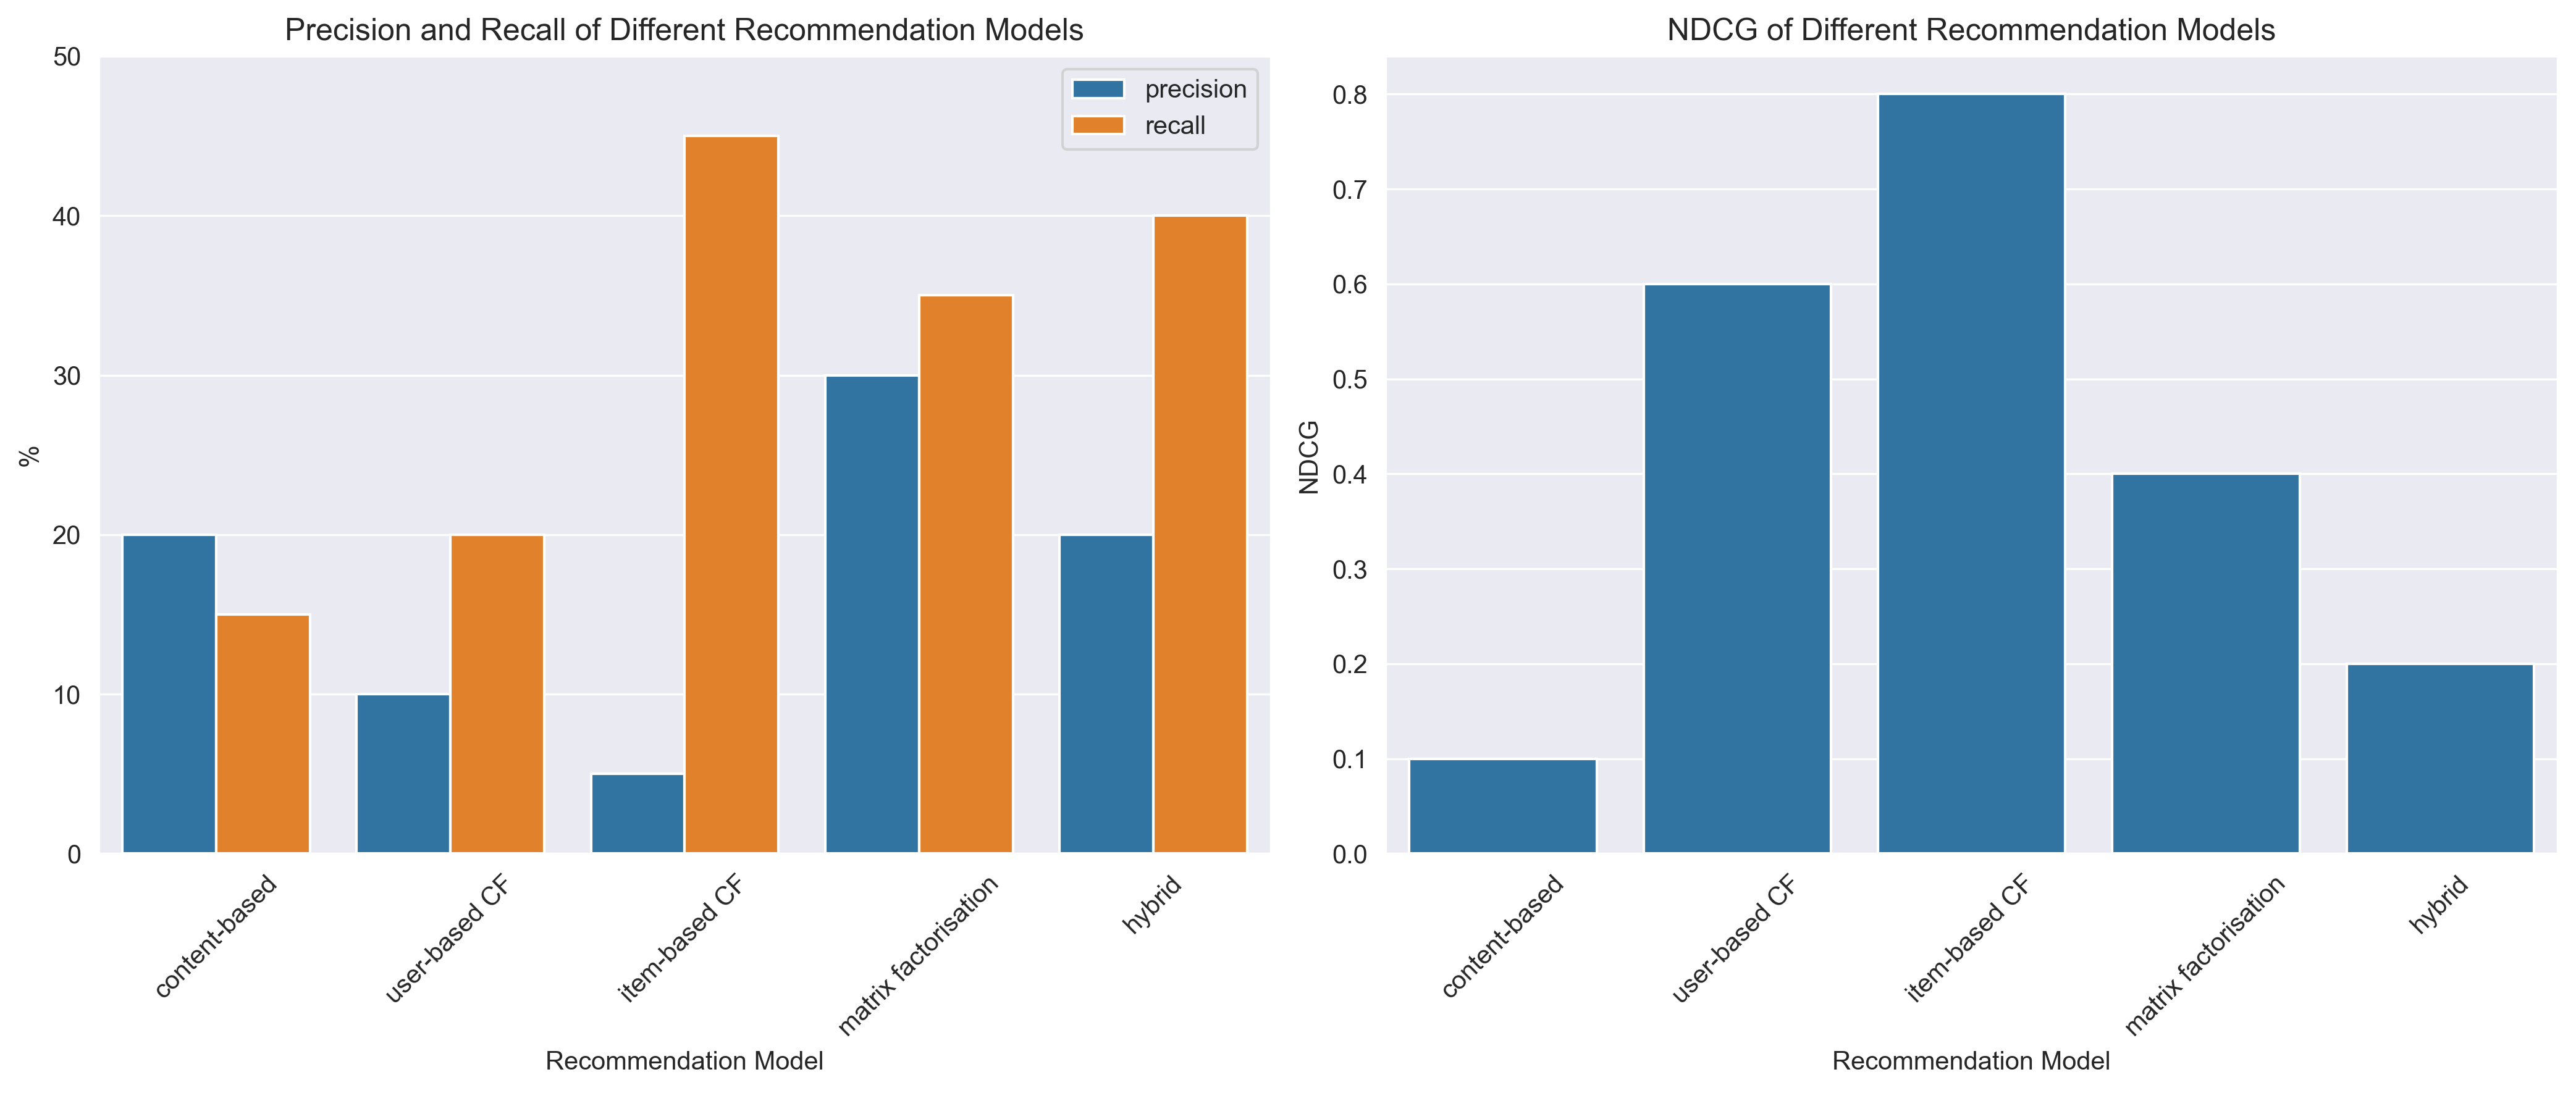

In [60]:
# VISUALISATION

results_ranking = {  # [precision, recall, ndcg]
    'content-based' : [20.0, 15.0, 0.1],
    'user-based CF' : [10.0, 20.0, 0.6],
    'item-based CF' : [05.0, 45.0, 0.8],
    'matrix factorisation' : [30.0, 35.0, 0.4],
    'hybrid' : [20.0, 40.0, 0.2],
}


def visualise_ranking_results(results: dict, tight: bool = False):
    """
    Plot Precision and Recall, and NDCG results for different recommendation models.

    :param tight: whether to display the two plots (Precision & Recall, NDCG) side by side
    :param results: dictionary where keys are model names and values are lists of [precision, recall, ndcg]
    """
    df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'})
    df_melt = df.melt(id_vars='model', value_vars=['precision', 'recall'], var_name='metric', value_name='value')

    if not tight:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melt, x='model', y='value', hue='metric', palette=['tab:blue', 'tab:orange'], errorbar=None)
        plt.title('Precision and Recall of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('%')
        plt.xticks(rotation=45)  # readability
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None)
        plt.title('NDCG of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('NDCG')
        plt.xticks(rotation=45)

    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        # Left - grouped Precision & Recall
        sns.barplot(data=df_melt, x='model', y='value', hue='metric',
                    palette=['tab:blue', 'tab:orange'], errorbar=None, ax=axes[0])
        axes[0].set_title('Precision and Recall of Different Recommendation Models')
        axes[0].set_xlabel('Recommendation Model')
        axes[0].set_ylabel('%')
        axes[0].set_ylim(0, df_melt['value'].max() + 5)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title=None)

        # Right - NDCG
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None, ax=axes[1])
        axes[1].set_title('NDCG of Different Recommendation Models')
        axes[1].set_xlabel('Recommendation Model')
        axes[1].set_ylabel('NDCG')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
    plt.show()

visualise_ranking_results(results_ranking, tight=True)

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

## Code

## Evaluation

You should be able to use the evaluation functions defined in Task 2 for evaluating the baselines as well (`evaluate_rating` and `evaluate_ranking`). Just call these for the combination of ground truth with the different predictions from the baselines.

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

# Task 5) Evaluation of beyond accuracy

## Diversity - ILD

- intra-list diversity - ILD - average pairwise distance
$$
ILD(L) = \frac{1}{|L|(|L|-1)} \sum_{i,j \in L}dist(i,j)
$$
- $dist(i,j)$ - distance function of how different $i$ and $j$ are -- genre difference
-
	- eg, embedding distance, categorical distance

In [ ]:
def diversity(rec_list, dist_func):
    """
    Calculate intra-list diversity (ILD) for a given recommendation list using a specified distance function.
    :param rec_list: top-k recommended item ids
    :param dist_func: function taking two item ids and returning a distance value - TODO - update / fix
    :return:
    """
    if len(rec_list) <= 1:
        return 0.0
    L = len(rec_list)
    frac = 1 / (L * (L - 1))
    total_dist = np.sum([dist_func(i,j) for i in rec_list for j in rec_list])

    return frac * total_dist

\[Discussion]

## Novelty - surprisal
- **self-information** - surprisal - measures how “surprising” an item is, based on its popularity
$$
novelty(i) = -\log_{2} pop(i)
$$

- $pop(i)$ - popularity of item $i$ - percentage of interactions on item $i$ = $\frac{num\_interactions\_on\_i}{total\_num\_interactions}$
  - from training data only?

In [ ]:
def popularity_matrix(train_data: pd.DataFrame) -> pd.Series:
    """
    Calculate the popularity of each item in the training data.
    :param train_data: training data
    :return: pd.Series with item ids as index and popularity as values
    """
    total_interactions = len(train_data)
    counts = train_data['item_id'].value_counts()
    popularity = counts / total_interactions
    return popularity

def novelty(rec_list: pd.Series, train_data: pd.DataFrame, weighting_scheme:str = 'uniform') -> float:
    """
    Calculate the novelty / surprisal of the items in a recommendation list
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param train_data: training data
    :param weighting_scheme: 'uniform' or 'log' - how to weight the novelty of items in the list\
    :return: novelty score
    """

    popularity = train_data['item_id'].value_counts(normalize=True)
    surprisal = -np.log2(popularity)

    # Find the weightings for the averaging
    if weighting_scheme == 'uniform':
        weights = np.ones(len(rec_list)) / len(rec_list)
    elif weighting_scheme == 'log':
        ranks = np.arange(1, len(rec_list) + 1)
        weights = 1 / np.log2(ranks + 1)  # TODO - check!
        weights /= np.sum(weights)
    else:
        raise ValueError("weighting_scheme must be 'uniform' or 'log'")

    surprisals = np.array([surprisal.loc[item] for item in rec_list.index.tolist()])
    novelty_score = np.sum(weights * surprisals)
    return novelty_score

\[Discussion]

## Calibration

**Calibration metric** - Kullback-Leibler divergence (lower = better)
$$
\displaylines{
MC_{KL}(p,q) = KL(p||q) = \sum_{g} p(g|u) \log \frac{p(g|u)}{q(g|u)} \\
p(g|u) = \frac{\sum_{i\in \mathcal{H}}w_{u,i} \times p(g|i)}{\sum_{i \in \mathcal{H}} w_{u,i}} \\
q(g|u) = \frac{\sum_{i\in \mathcal{L}}w_{r(i)} \times p(g|i)}{\sum_{i \in \mathcal{L}} w_{r(i)}}
}
$$

- $p(g|i)$ - genre-distribution of each movie - categorisation of item
- $p(g|u)$ - distribution of genres $g$ in user $u$'s profile (based on training data)
    - $\mathcal{H}$ - interaction history
    - $w_{u,i}$ - weight of item $i$	- how recently played, playing duration, rating value, ...
- $q(g|u)$ - distribution of genres $g$ in the recommendation list for
    - $\mathcal{L}$ - recommended items
    - $w_{r(i)}$ - weight of item $i$ at rank $r(i)$ - weighting scheme used in ranking metrics - EG, MRR, nDCG
- to avoid division by zero - $\tilde{q}(g|u) = (1-\alpha) \cdot q(g|u) + \alpha \cdot p(g|u)$ with small $\alpha > 0$, s.t. $q \approx\tilde{q}$

In [6]:
def genre_distribution(movies: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate genre distribution for each movie.
    :param movies: [pd.DataFrame] containing movie metadata with columns=['item_id','title','genres','description']
    :return: pd.dataframe with all genres as columns, item id's as index, and p(g|i) as values
    """
    mov_genres = movies[['item_id', 'genres']].copy()
    mov_genres['genres'] = mov_genres['genres'].apply(lambda x: x.split(',')) # make the genres a list
    item_ids = mov_genres['item_id'].unique()
    # find all the genres present in the dataset
    all_genres = set()
    for genres in mov_genres['genres']:
        all_genres.update(genres)
    all_genres = list(all_genres)

    # calculate the distributions
    genre_dist = pd.DataFrame(np.zeros((len(item_ids), len(all_genres))), columns=all_genres, index=item_ids)
    for _, row in mov_genres.iterrows():
        item_id = row['item_id']
        genres = row['genres']
        genre_count = len(genres)
        for genre in genres:
            genre_dist.at[item_id, genre] = 1 / genre_count  # uniform distribution over genres
    return genre_dist

genre_distributions = genre_distribution(movies)
display(genre_distributions.head())

,Children's,Sci-Fi,Film-Noir,Animation,Romance,Musical,unknown,Drama,Crime,Mystery,...,Horror,Horror,Children's,Thriller,Animation,Sci-Fi,Adventure,Drama,Comedy,Crime
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.333333


In [ ]:
def get_interaction_history(user_id, train_data: pd.DataFrame) ->  pd.Series:
    """
    Get interaction history of a user from training data.
    :param user_id: user id
    :param train_data: training data dataframe
    :return: list of item ids the user has interacted with
    """
    user_history = train_data[train_data['user_id'] == user_id]
    return user_history[['item_id', 'rating']].set_index('item_id')['rating']

In [ ]:
def compute_genre_distribution_of_user(genre, genre_dist: pd.DataFrame, history: pd.Series):
    """
    Helper function for calibration metric - compute p(g|u) / q(g|u) for a given genre and user interaction history.

    Formulas are basically equivalent:  (idk equations work here)
    $$
    \displaylines{
        p(g|u) = \frac{\sum_{i\in \mathcal{H}}w_{u,i} \times p(g|i)}{\sum_{i \in \mathcal{H}} w_{u,i}} \\
        q(g|u) = \frac{\sum_{i\in \mathcal{L}}w_{r(i)} \times p(g|i)}{\sum_{i \in \mathcal{L}} w_{r(i)}}
    }
    $$

    :param genre: genre to compute distribution for
    :param genre_dist: pd.DataFrame with all genres as columns, item id's as index, and p(g|i) as values
    :param history: pd.Series of item ids and ratings the user has interacted with, index=item ids, values=ratings
    :return:
    """
    pgi = [genre_dist.at[item, genre] for item in history.index.tolist()]
    ratings = history.values
    weighted_sum = np.sum(np.array(pgi) * np.array(ratings))
    return weighted_sum / np.sum(ratings)


In [ ]:
def calibration(rec_list: pd.Series, user, train_data: pd.DataFrame, movie_data: pd.DataFrame) -> float:
    """
    Calculate calibration metric for a given recommendation list and user.
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param user: user for whom the recommendation was made
    :param train_data: training data
    :param movie_data:
    :return:
    """
    a = 0.00000000001  # small alpha to avoid division by zero
    genre_dist = genre_distribution(movie_data) # p(g|i)
    genres = genre_dist.columns.tolist()

    # pgu - genre distribution in user profile
    user_history = get_interaction_history(user, train_data) # H
    pgu = np.array([compute_genre_distribution_of_user(g, genre_dist, user_history) for g in genres]) # p(g|u)

    # qgu - genre distribution in recommendation list
    qgu = np.array([compute_genre_distribution_of_user(g, genre_dist, rec_list) for g in genres]) # q(g|u)
    qgu = (1 - a) * qgu + a * pgu # avoid division by zero

    # result
    res = np.sum(pgu * np.log(pgu / qgu))
    return res

# TODO - check!

\[Discussion]

## Fairness

Types:
- User-side - RecSys serve individual users/groups equally
    - Group Recommendation Unfairness - GRU
    - User Popularity Deviation - UPD
- Item-side - fair representation of items \<--
    - catalog coverage - fraction of items recommended at least once (need results for all rankings (item-user pairs))
    - equality of exposure - entropy, gini index
    - demographic parity - exposure to each group should be $\propto$ group size
    - disparate treatment - exposure to each group should be $\propto$ group utility / merit
    - disparate impact - exposure to each group should be according to expected group attention to group utility/merit

In [ ]:
%%sql


### User-side fairness

$$
\displaylines{
GRU(G_1, G_2, Q) = \left| \frac{1}{|G_1|} \sum_{i \in G_1} \mathcal{F} (Q_i) - \frac{1}{|G_2|} \sum_{i \in G_2} \mathcal{F}(Q_i) \right| \\
UPD(u) = dist(P(R_u), P(L_u))
}
$$

- $\mathcal{F}(Q_i)$ - recommendation quality for user $u_i$, invoking a metric such as NDCG@K or F1 score
- $P(R_u)$ - popularity distribution of items in user $u$'s recommendation list
- $P(L_u)$ - popularity distribution of items in user $u$'s interaction history

In [ ]:
def group_rec_unfairness(group1: list, group2: list, metric: str, rank_scores: pd.DataFrame) -> float:
    """
    Calculate Group Recommendation Unfairness (GRU) between two user groups, given a quality metric.
    :param group1: list of user ids in group 1
    :param group2: list of user ids in group 2
    :param metric: metric to use - ['nDCG', 'Precision', 'Recall', ...] - should match the column names in rank_scores
    :param rank_scores: scores of ranking tasks
    :return: GRU value as a float
    """
    g1_size = len(group1)
    g2_size = len(group2)
    if g1_size == 0 or g2_size == 0:
        return 0.0  # cannot compare a group w/ no users

    g1_avg = np.mean(rank_scores.at[group1, metric]) / g1_size
    g2_avg = np.mean(rank_scores.at[group2, metric]) / g2_size
    return g1_avg - g2_avg

In [ ]:
def user_popularity_bias(user_id, rec_list: pd.Series, train_data: pd.DataFrame, ) -> float:
    item_popularity = popularity_matrix(train_data)
    user_history = get_interaction_history(user_id, train_data)
    p_ru = item_popularity.loc[rec_list.index.tolist()]
    p_lu = item_popularity.loc[user_history.index.tolist()]
    return np.mean(p_ru) - np.mean(p_lu)

### Item-side fairness

In [ ]:
def catalog_coverage(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float:
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    recommended_items = set()
    for rec_list in rec_lists:
        recommended_items.update(rec_list.index.tolist())
    no_recommended_items = len(recommended_items)
    return no_recommended_items / total_no_movies

In [ ]:
def equality_of_exposure(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float: # TODO - go over
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    exposure_counts = pd.Series(0, index=movie_data['item_id'].tolist())
    for rec_list in rec_lists:
        for item in rec_list.index.tolist():
            exposure_counts.at[item] += 1
    exposure_probs = exposure_counts / exposure_counts.sum()
    gini_index = 1 - 2 * np.sum(exposure_probs.cumsum() * (1 / total_no_movies))
    return gini_index

Exposure:
$$
\text{Exposure}(G_k) = \frac{1}{|G_k|} \sum_{i \in G_k} \frac{1}{\log_2 (1 + pos(i))}
$$
 ^ unsure how to implement with worth

In [ ]:
def exposure(group: list):

    pass